# Energy efficiency modeling: residential building

### Objective  
Develop regression models to predict residential building heating and cooling loads based on architectural features.

### Dataset  
[Kaggle - Energy Efficiency Data Set](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set)

### Input Variables  
- Relative compactness  
- Roof area  
- Overall height  
- Surface area  
- Glazing area  
- Wall area  
- Glazing area distribution of a building  
- Orientation  

### Target Variables  
- Heating load  
- Cooling load


## 1. Data Analysis & Cleaning

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from math import sqrt
import sys
%matplotlib inline

import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import hyperopt
import catboost
from catboost import CatBoostRegressor
from catboost.utils import get_roc_curve
from catboost.utils import eval_metric
import  warnings
warnings.simplefilter('ignore')
import shap

In [2]:
pd.set_option("display.max_columns", None)
mpl.rcParams['figure.figsize'] = (12, 10)
#plt.rcParams['axes.labelsize'] = 15
font = {'weight' : 'bold', 'size'   : 15}
plt.rc('font', **font)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
data = pd.read_csv('energy_efficiency_data.csv')
data.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


### 1.1 Understanding the dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [5]:
data.isnull().sum()

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

In [6]:
data.shape

(768, 10)

In [7]:
data.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [8]:
col_num = data.select_dtypes(exclude = ['object']).columns.tolist()
col_num

['Relative_Compactness',
 'Surface_Area',
 'Wall_Area',
 'Roof_Area',
 'Overall_Height',
 'Orientation',
 'Glazing_Area',
 'Glazing_Area_Distribution',
 'Heating_Load',
 'Cooling_Load']

array([[<AxesSubplot:title={'center':'Relative_Compactness'}>,
        <AxesSubplot:title={'center':'Surface_Area'}>,
        <AxesSubplot:title={'center':'Wall_Area'}>],
       [<AxesSubplot:title={'center':'Roof_Area'}>,
        <AxesSubplot:title={'center':'Overall_Height'}>,
        <AxesSubplot:title={'center':'Orientation'}>],
       [<AxesSubplot:title={'center':'Glazing_Area'}>,
        <AxesSubplot:title={'center':'Glazing_Area_Distribution'}>,
        <AxesSubplot:title={'center':'Heating_Load'}>],
       [<AxesSubplot:title={'center':'Cooling_Load'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

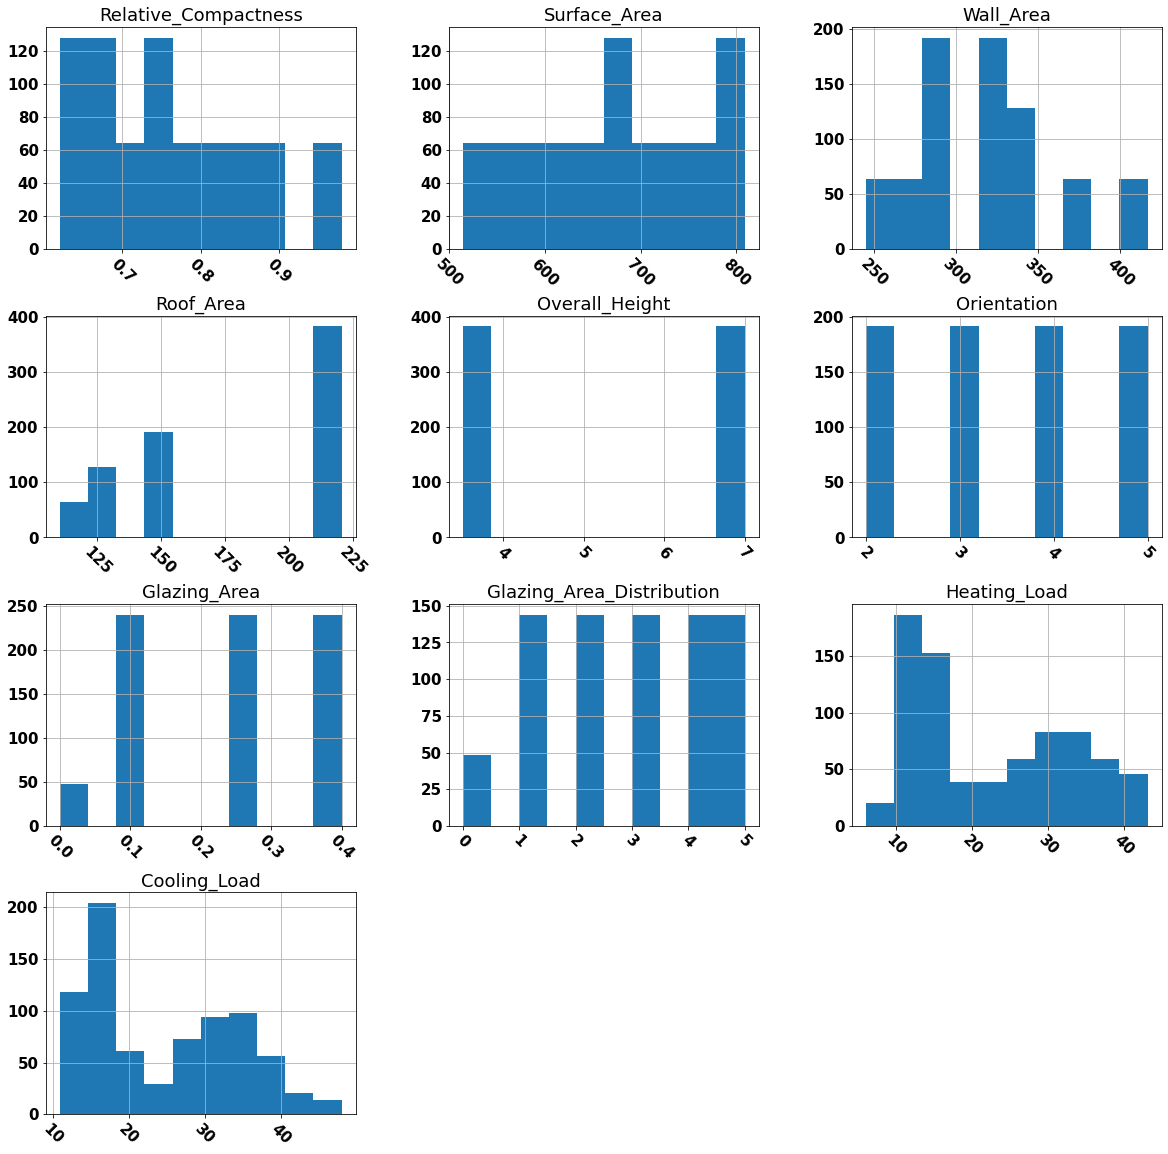

In [9]:
data.hist(figsize=(20,20), xrot=-45)

#### Correlation heatmap for all numerical features

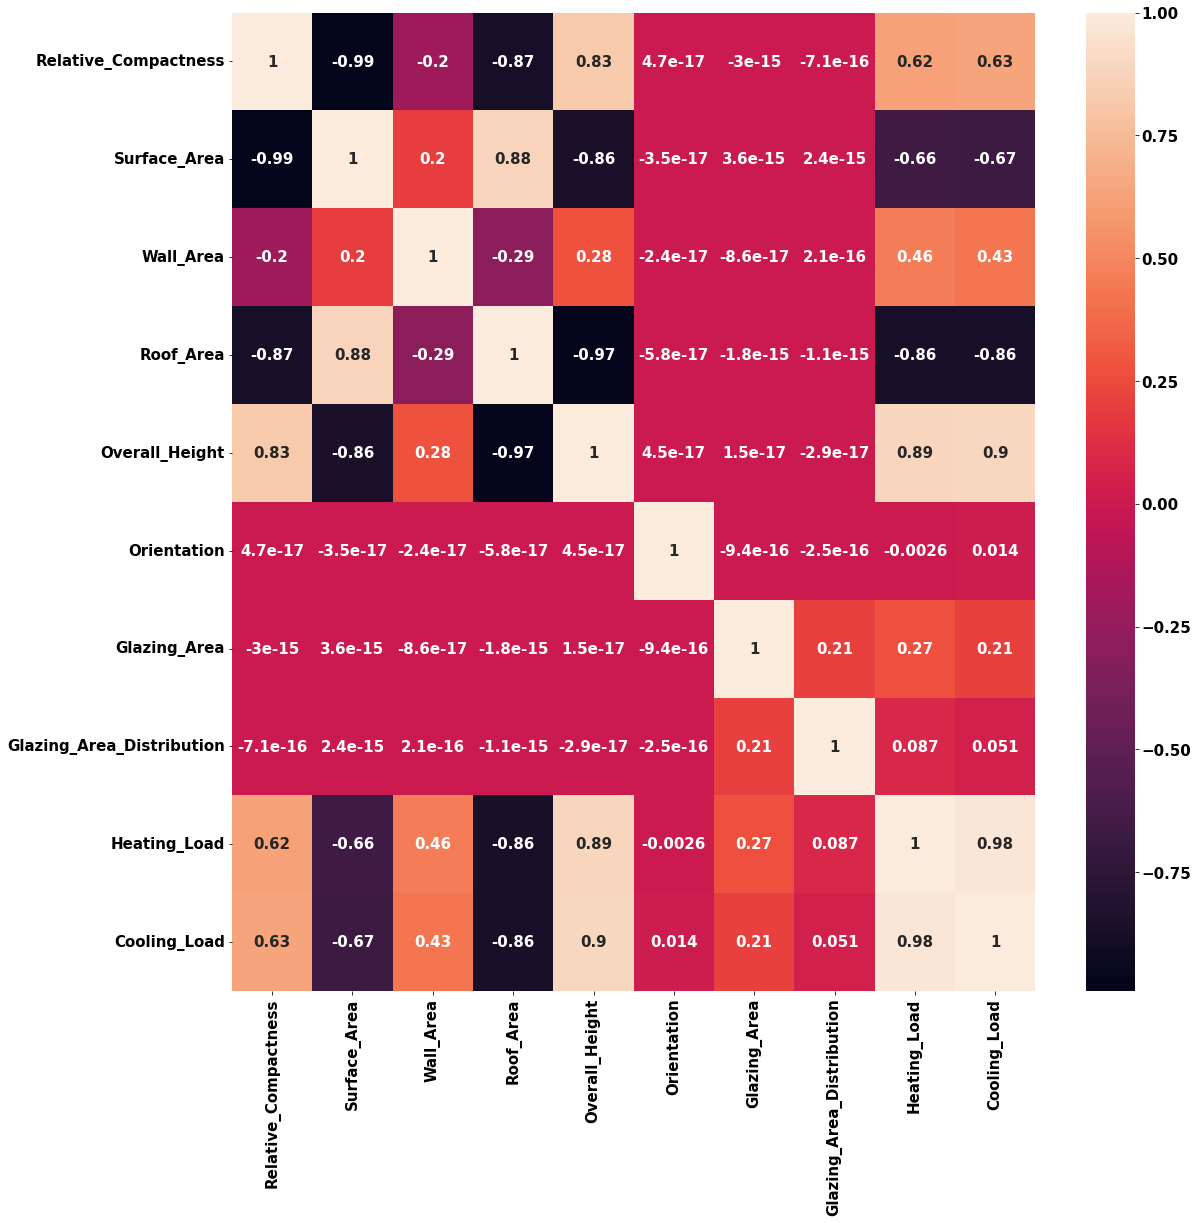

In [11]:
plt.figure(figsize=(18,18))
sns.heatmap(data.select_dtypes(['float64' , 'int64']).corr(),annot=True)
plt.show()

Several variables are highly correlated. For example, relative_compactness, surface_area, and roof_area are all highly correlated. This multicollinearity might affect linear model performance, as linear regression features should be independent.

In [24]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates().dropna()
    return xFlattened

corrFilter(data, .7)

Relative_Compactness  Surface_Area           -0.991901
Overall_Height        Roof_Area              -0.972512
Relative_Compactness  Roof_Area              -0.868823
Cooling_Load          Roof_Area              -0.862547
Roof_Area             Heating_Load           -0.861828
Surface_Area          Overall_Height         -0.858148
Overall_Height        Relative_Compactness    0.827747
Surface_Area          Roof_Area               0.880720
Overall_Height        Heating_Load            0.889431
Cooling_Load          Overall_Height          0.895785
Heating_Load          Cooling_Load            0.975862
dtype: float64

In [14]:
corr1 = data.corr()[['Cooling_Load']].sort_values(by='Cooling_Load', ascending=False)
corr1

,Cooling_Load
Cooling_Load,1.000000
Heating_Load,0.975862
Overall_Height,0.895785
Relative_Compactness,0.634339
Wall_Area,0.427117
Glazing_Area,0.207505
Glazing_Area_Distribution,0.050525
Orientation,0.014290
Surface_Area,-0.672999
Roof_Area,-0.862547


In [15]:
corr2 = data.corr()[['Heating_Load']].sort_values(by='Heating_Load', ascending=False)
corr2

,Heating_Load
Heating_Load,1.000000
Cooling_Load,0.975862
Overall_Height,0.889431
Relative_Compactness,0.622272
Wall_Area,0.455671
Glazing_Area,0.269841
Glazing_Area_Distribution,0.087368
Orientation,-0.002587
Surface_Area,-0.658120
Roof_Area,-0.861828


For linear models, several variables need to be removed from the feature list: ['Roof_Area','Surface_Area','Relative_Compactness']

In [17]:
#save a copy of data for ensemble modeling
data_ensemble = data

In [18]:
data.to_csv('data_processed.csv', index=False) # Now, output to cleaned & engineered data for use

## 3. Modeling
### 3.1. Baseline model-- regularized linear regression

#### Data preparation for linear regression

In [19]:
df = pd.read_csv('data_processed.csv')

In [20]:
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [22]:
#drop highly correlated features
df = df.drop(columns=['Roof_Area','Surface_Area','Relative_Compactness'], axis =1)

In [27]:
y = df[['Heating_Load', 'Cooling_Load']]
X = df.drop(['Heating_Load','Cooling_Load'], axis=1)
y1 = df[['Heating_Load']]
y2 = df[['Cooling_Load']]

In [28]:
#test_train splitting
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.33, random_state=1234)

#### L1 and L2 regularized linear models

In [29]:
#we use L1 and L2 regularized linear models;
#L1 lasso many coefficients are zeroed out and leads to sparser models;
#feature normalization also happen within the pipeline
pipelines = {
    'lasso' : make_pipeline(StandardScaler(),
              Lasso(random_state=123, tol=1e-2, max_iter=10000)),
    'ridge' : make_pipeline(StandardScaler(),
              Ridge(random_state=123,  tol=1e-2, max_iter=10000))
}

In [31]:
#lasso：the higher the alpha, the most feature coefficients are zero.
#ridge: the higher the alpha, the impact of coefficient shrinkage grows 
lasso_hyperparameters = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
ridge_hyperparameters = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10]}

hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters   
}

Predicting Heating_Load

In [32]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=10
                         )
    model.fit(X_train, y1_train)
    fitted_models[name] = model

In [78]:
#give R2 as the performance score

for name, model in fitted_models.items():
    print("R^2 for Heating_Load (train data):{}".format(model.best_score_))
    print("Best Hyperparameters:\n{}".format(model.best_params_))

R^2 for Heating_Load (train data):0.8778388268589534
Best Hyperparameters:
{'lasso__alpha': 0.01}
R^2 for Heating_Load (train data):0.8778404921310858
Best Hyperparameters:
{'ridge__alpha': 1}


In [37]:
#apply model to test data
#use R2 and MAE as the metrics: mae measures the average of the residuals. mse measures the variance of the residuals
#adding more features always increase the r2, can serve as a signal for high model complexity (overfitting)
print("R^2 and MAE for Heating_Load prediction (test data):")
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print(' — — — —' )
    print('R²:', r2_score(y1_test, pred))
    print('MAE:', mean_absolute_error(y1_test, pred))
    print()

R^2 and MAE for Heating_Load prediction (test data):
lasso
 — — — —
R²: 0.9145825821538098
MAE: 2.1598658498805854

ridge
 — — — —
R²: 0.9141388168453861
MAE: 2.17463129484538



Predicting Cooling_Load

In [39]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=10
                         )
    model.fit(X_train, y2_train)
    fitted_models[name] = model

In [79]:
#give R2 as the performance score
for name, model in fitted_models.items():
    print("R^2 for Cooling_Load (train data):{}".format(model.best_score_))
    print("Best Hyperparameters:\n{}".format(model.best_params_))

R^2 for Cooling_Load (train data):0.8778388268589534
Best Hyperparameters:
{'lasso__alpha': 0.01}
R^2 for Cooling_Load (train data):0.8778404921310858
Best Hyperparameters:
{'ridge__alpha': 1}


In [41]:
#apply model to test data
#use R2 and MAE as the metrics: mae measures the average of the residuals. mse measures the variance of the residuals
#adding more features always increase the r2, can serve as a signal for high model complexity (overfitting)
print("R^2 and MAE for Cooling_Load prediction (test data):")
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print(' — — — —' )
    print('R²:', r2_score(y2_test, pred))
    print('MAE:', mean_absolute_error(y2_test, pred))
    print()

R^2 and MAE for Cooling_Load prediction (test data):
lasso
 — — — —
R²: 0.8780502312567185
MAE: 2.407818457358931

ridge
 — — — —
R²: 0.8779766802731875
MAE: 2.4091947191431453



### 3.2 Ensemble models -- Catboosting, Random Forest, Gradient Boosting

In [63]:
df = pd.read_csv('data_processed.csv')
y = df[['Heating_Load', 'Cooling_Load']]
X = df.drop(['Heating_Load','Cooling_Load'], axis=1)
y1 = df[['Heating_Load']]
y2 = df[['Cooling_Load']]

In [64]:
#test_train splitting
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.33, random_state=1234)

In [70]:
regressors = [['Catboostregressor', CatBoostRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()]]

In [71]:
r2 = pd.DataFrame(index=None, columns=['model','train_Heating','test_Heating','train_Cooling','test_Cooling'])

In [72]:
for regressor in regressors:
    name = regressor[0]
    model = regressor[1]
    
    model.fit(X_train,y1_train)
    r2_train1 = r2_score(y1_train, model.predict(X_train))
    r2_test1 = r2_score(y1_test, model.predict(X_test))
    
    model.fit(X_train,y2_train)
    r2_train2 = r2_score(y2_train, model.predict(X_train))
    r2_test2 = r2_score(y2_test, model.predict(X_test))
    
    r2 = r2.append(pd.Series({'model':name, 'train_Heating':r2_train1,'test_Heating':r2_test1,'train_Cooling':r2_train2,'test_Cooling':r2_test2}),ignore_index=True )
r2.sort_values(by='test_Cooling')

Learning rate set to 0.03467
0:	learn: 9.7532005	total: 584us	remaining: 584ms
1:	learn: 9.4595688	total: 1.26ms	remaining: 631ms
2:	learn: 9.2086476	total: 1.86ms	remaining: 617ms
3:	learn: 8.9273986	total: 2.51ms	remaining: 624ms
4:	learn: 8.6967847	total: 3.02ms	remaining: 601ms
5:	learn: 8.4376315	total: 3.68ms	remaining: 609ms
6:	learn: 8.2272231	total: 4.18ms	remaining: 593ms
7:	learn: 7.9982062	total: 4.78ms	remaining: 592ms
8:	learn: 7.7615568	total: 5.76ms	remaining: 634ms
9:	learn: 7.5387620	total: 6.32ms	remaining: 626ms
10:	learn: 7.3249396	total: 6.99ms	remaining: 629ms
11:	learn: 7.1089355	total: 7.65ms	remaining: 630ms
12:	learn: 6.9341315	total: 8.29ms	remaining: 629ms
13:	learn: 6.7570379	total: 9ms	remaining: 634ms
14:	learn: 6.5644935	total: 9.66ms	remaining: 634ms
15:	learn: 6.3913362	total: 10.3ms	remaining: 636ms
16:	learn: 6.2079486	total: 11ms	remaining: 635ms
17:	learn: 6.0449097	total: 11.5ms	remaining: 628ms
18:	learn: 5.8843080	total: 12ms	remaining: 619ms
1

,model,train_Heating,test_Heating,train_Cooling,test_Cooling
1,SVR,0.671160,0.681328,0.667231,0.665227
2,RandomForestRegressor,0.999652,0.997674,0.995188,0.967114
3,GradientBoostingRegressor,0.998310,0.997560,0.979275,0.976941
0,Catboostregressor,0.999818,0.998703,0.998912,0.995273


In [73]:
r2

,model,train_Heating,test_Heating,train_Cooling,test_Cooling
0,Catboostregressor,0.999818,0.998703,0.998912,0.995273
1,SVR,0.671160,0.681328,0.667231,0.665227
2,RandomForestRegressor,0.999652,0.997674,0.995188,0.967114
3,GradientBoostingRegressor,0.998310,0.997560,0.979275,0.976941


#### 3.2.1 Hyperparameter Tuning -Catboosting

In [ ]:
model_CBR = CatBoostRegressor(verbose=0)
parameters = { 'depth': [6, 8, 10],
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'random_strength': [1, 5],
    'min_data_in_leaf': [1, 10, 20]
}

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y2_train)

print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

In [ ]:
predictions = cb.predict(X_test)
mae = mean_absolute_error(y1_test, predictions)
r2 = r2_score(y1_test, predictions)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

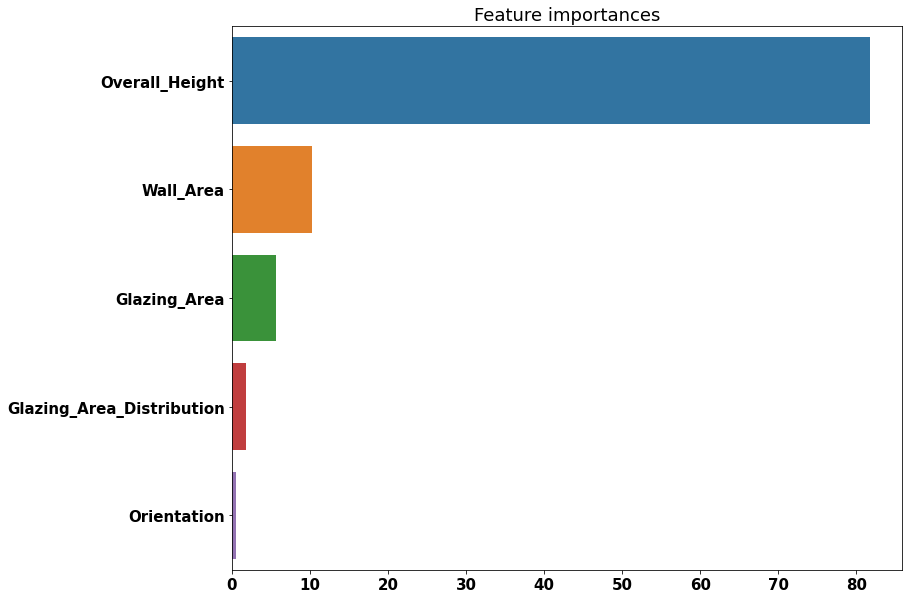

In [43]:
importances = cb.feature_importances_
cb_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

ax = sns.barplot(y=cb_importances.index, x = cb_importances.values).set(title='Feature importances')
plt.show()


In [44]:
predictions = cb.predict(X_test)

In [47]:
mae = mean_absolute_error(y1_test, predictions)
r2 = r2_score(y1_test, predictions)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error: 1.04
R² Score: 0.9671


Catboost's default setting is already giving the lowest MAE amongst other models!

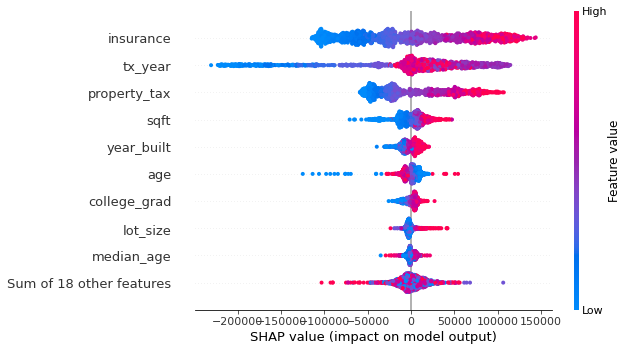

In [57]:
#get shap values
explainer = shap.Explainer(cb)
shap_values = explainer(X_train_ens)
shap.plots.beeswarm(shap_values)

## 4.Results

#### 3 different models are tested with MAE:
* Lasso (tuned): 46052
* Ridge (tuned): 45025
* Catboost (default): 43525


Next Step: Tuning parameters of Catboosting model, such as learning_rate, depth, l2_leaf_reg, etc.
There is no overfitting on the last iterations of training (the training does not converge) — increase the learning rate.
Overfitting is detected — decrease the learning rate
Values in the range from 6 to 10 are recommended.
coefficient at the L2 regularization term of the cost function.  2 and 30, is a good starting point.